<a href="https://colab.research.google.com/github/konamilk/mlb-player-digital-engagement-forecasting/blob/main/MLB_lightGBM_forked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training

In [1]:
import sys
from pathlib import Path

In [2]:
# # Install_LightGBM_with_GPU
# if 'google.colab' in sys.modules:
#     ! git clone --recursive https://github.com/Microsoft/LightGBM

#     %cd /content/LightGBM
#     ! mkdir -p build

#     %cd build
#     ! cmake -DUSE_GPU=1 /content/LightGBM
#     ! make -j$(nproc)
#     ! sudo apt-get -y install python-pip
#     ! sudo -H pip install setuptools pandas numpy scipy scikit-learn -U

#     %cd /content/LightGBM/python-package
#     ! sudo python setup.py install --precompile

#     %cd /content/

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
from functools import reduce
from tqdm import tqdm
import lightgbm as lgbm
import datetime
import gc

In [4]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = Path('/content/input/mlb-player-digital-engagement-forecasting')
    TRAIN_DIR = Path('/content/input/mlb-pdef-train-dataset')
    !mkdir output
    OUTPUT_DIR = Path('/content/output')
elif 'kaggle_web_client' in sys.modules:
    BASE_DIR = Path('../input/mlb-player-digital-engagement-forecasting')
    TRAIN_DIR = Path('../input/mlb-pdef-train-dataset')
    OUTPUT_DIR = Path('../output')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘output’: File exists


In [5]:
if 'google.colab' in sys.modules:
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/.kaggle/kaggle.json ~/.kaggle
    !chmod 600 ~/.kaggle/kaggle.json
    !pip install kaggle > /dev/null
    !mkdir input
    # original datasets
    !kaggle competitions download -c mlb-player-digital-engagement-forecasting
    !mkdir input/mlb-player-digital-engagement-forecasting
    !unzip -o '*.zip' -d ./input/mlb-player-digital-engagement-forecasting
    !mv *.csv ./input/mlb-player-digital-engagement-forecasting
    !rm *.zip
    # MLB_PDEF_train_dataset
    !kaggle datasets download -d columbia2131/mlb-pdef-train-dataset
    !mkdir input/mlb-pdef-train-dataset
    !unzip -o '*.zip' -d ./input/mlb-pdef-train-dataset
    !rm *.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘input’: File exists
__init__.py: Skipping, found more recently modified local copy (use --force to force download)
competition.cpython-37m-x86_64-linux-gnu.so: Skipping, found more recently modified local copy (use --force to force download)
  0% 0.00/191k [00:00<?, ?B/s]
100% 191k/191k [00:00<00:00, 29.5MB/s]
  0% 0.00/3.68k [00:00<?, ?B/s]
100% 3.68k/3.68k [00:00<00:00, 3.02MB/s]
  0% 0.00/173k [00:00<?, ?B/s]
100% 173k/173k [00:00<00:00, 55.6MB/s]
  0% 0.00/824 [00:00<?, ?B/s]
100% 824/824 [00:00<00:00, 693kB/s]
  0% 0.00/3.96M [00:00<?, ?B/s]
100% 3.96M/3.96M [00:00<00:00, 65.1MB/s]
 99% 463M/470M [00:04<00:00, 108MB/s]
100% 470M/470M [00:04<00:00, 118MB/s]
  0% 0.00/820k [00:00<?, ?B/s]
100% 820k/820k [00:00<00:00, 114MB/s]
mkdir: cannot create directory ‘input/mlb-player-digital-engagement-forecasting’: File exists
Archive:  example_test.csv.zip
  inflating: ./input/mlb-player-digital-enga

In [6]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName', 'DOB']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

feature_cols = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
       'isBirthday', 'playerFollowers', 'teamFollowers',
    #    'year', 'month', 'day', 'dayofweek',
       'preSeason', 'regularSeason', '1stHalf', '2ndHalf', 'allStar', 'postSeason',
       ]

In [7]:
players = pd.read_csv(BASE_DIR / 'players.csv')
rosters = pd.read_pickle(TRAIN_DIR / 'rosters_train.pkl')
targets = pd.read_pickle(TRAIN_DIR / 'nextDayPlayerEngagement_train.pkl')
scores = pd.read_pickle(TRAIN_DIR / 'playerBoxScores_train.pkl')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()

In [8]:
playerFollowers = pd.read_pickle(TRAIN_DIR/'playerTwitterFollowers_train.pkl').drop(['index'], axis=1)
playerFollowers = playerFollowers[playerFollowers['date'] != 20210401]
teamFollowers = pd.read_pickle(TRAIN_DIR/'teamTwitterFollowers_train.pkl').drop(['index'], axis=1)
teamFollowers = teamFollowers[teamFollowers['date'] != 20210401]

In [9]:
seasons = pd.read_csv(BASE_DIR / 'seasons.csv')
for col in seasons.columns:
    if col == 'seasonId':
        continue
    seasons[col] = pd.to_datetime(seasons[col])

In [10]:
# creat dataset
train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')

train['_date'] = pd.to_datetime(train['date'].astype(str))
train['year'] = train['_date'].dt.year
train['month'] = train['_date'].dt.month
train['day'] = train['_date'].dt.day
train['dayofweek'] = train['_date'].dt.dayofweek

# add followers
train['_date_ym'] = train['date'] // 100
playerFollowers['_date_ym'] = playerFollowers['date'] // 100
playerFollowers['playerFollowers'] = playerFollowers['numberOfFollowers']
train = train.merge(playerFollowers[['playerId', '_date_ym', 'playerFollowers']], on=['playerId', '_date_ym'], how='left')
playerFollowers.drop(['_date_ym', 'playerFollowers'], axis=1, inplace=True)

teamFollowers['_date_ym'] = teamFollowers['date'] // 100
teamFollowers['teamFollowers'] = teamFollowers['numberOfFollowers']
train = train.merge(teamFollowers[['teamId', '_date_ym', 'teamFollowers']], on=['teamId', '_date_ym'], how='left')
teamFollowers.drop(['_date_ym', 'teamFollowers'], axis=1, inplace=True)
train.drop('_date_ym', axis=1, inplace=True)

# label encoding
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)

# add season
train['preSeason'] = False
train['regularSeason'] = False
train['1stHalf'] = False
train['2ndHalf'] = False
train['allStar'] = False
train['postSeason'] = False
for _, row in seasons.iterrows():
    train['preSeason'] = train['preSeason'] | ((row['preSeasonStartDate'] <=  train['_date']) & (train['_date'] <= row['preSeasonEndDate']))
    train['regularSeason'] = train['regularSeason'] | ((row['regularSeasonStartDate'] <=  train['_date']) & (train['_date'] <= row['regularSeasonEndDate']))
    train['1stHalf'] = train['1stHalf'] | ((row['regularSeasonStartDate'] <=  train['_date']) & (train['_date'] <= row['lastDate1stHalf']))
    train['2ndHalf'] = train['2ndHalf'] | ((row['firstDate2ndHalf'] <=  train['_date']) & (train['_date'] <= row['regularSeasonEndDate']))
    train['allStar'] = train['allStar'] | (row['allStarDate'] ==  train['_date'])
    train['postSeason'] = train['postSeason'] | ((row['postSeasonStartDate'] <=  train['_date']) & (train['_date'] <= row['postSeasonEndDate']))

# feature engineering
train['DOB'] = pd.to_datetime(train['DOB'])
train['isBirthday'] = train['date'] % 1000 == train['DOB'].dt.month * 100 + train['DOB'].dt.day

# train.drop('_date', axis=1, inplace=True)

In [11]:
train_X = train[feature_cols]
train_y = train[['target1', 'target2', 'target3', 'target4']]

# _index = (train['date'] < 20210301)
x_train = train_X.loc[train['date'] < 20210301].reset_index(drop=True)
y_train = train_y.loc[train['date'] < 20210301].reset_index(drop=True)
x_valid = train_X.loc[(train['date'] >= 20210301) & (train['date'] < 20210401)].reset_index(drop=True)
y_valid = train_y.loc[(train['date'] >= 20210301) & (train['date'] < 20210401)].reset_index(drop=True)


In [12]:
gc.collect()

176

In [13]:
%%time
def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params)
    model.fit(x_train, y_train, 
        eval_set=[(x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=verbose)
    oof_pred = model.predict(x_valid)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    return oof_pred, model, score


# training lightgbm
params = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 80000,
 'learning_rate': 0.1,
 'random_state': 42,
#  'device': 'gpu',
}

oof1, model1, score1 = fit_lgbm(
    x_train, y_train['target1'],
    x_valid, y_valid['target1'],
    params
)
oof2, model2, score2 = fit_lgbm(
    x_train, y_train['target2'],
    x_valid, y_valid['target2'],
    params
)
oof3, model3, score3 = fit_lgbm(
    x_train, y_train['target3'],
    x_valid, y_valid['target3'],
    params
)
oof4, model4, score4 = fit_lgbm(
    x_train, y_train['target4'],
    x_valid, y_valid['target4'],
    params
)

score = (score1+score2+score3+score4) / 4
print(f'score: {score}')

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 0.932747
Early stopping, best iteration is:
[33]	valid_0's l1: 0.932719
mae: 0.9327185656498003
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 2.73779
[200]	valid_0's l1: 2.73501
Early stopping, best iteration is:
[116]	valid_0's l1: 2.73379
mae: 2.7337927123338686
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 0.966394
Early stopping, best iteration is:
[87]	valid_0's l1: 0.966393
mae: 0.9663926789087673
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 1.86249
[200]	valid_0's l1: 1.83
[300]	valid_0's l1: 1.81951
[400]	valid_0's l1: 1.80534
[500]	valid_0's l1: 1.80311
[600]	valid_0's l1: 1.79909
[700]	valid_0's l1: 1.79391
[800]	valid_0's l1: 1.79121
[900]	valid_0's l1: 1.79113
Early stopping, best iteration is:
[877]	valid_0's l1: 1.79113
mae: 1.7911336495750323
score: 1.6060094016168671
CPU times: 

In [14]:
class TestDataset(object):
  def __init__(self, batch_size=5):
    self.current = 0
    self.batch_size = batch_size
    _df = pd.read_csv(BASE_DIR/ 'train.csv')
    self.df_test = _df[_df['date'] >= 20210401]

  def __iter__(self):
    return self

  def __next__(self):
    start = self.current * self.batch_size
    end = (self.current + 1) * self.batch_size
    self.current += 1

    if start >= self.df_test.shape[0]:
      raise StopIteration()

    # df_example_test
    df_example_test = self.df_test[start:end].drop('nextDayPlayerEngagement', axis=1)
    df_example_test.set_index('date', inplace=True)

    # df_example_sample_submission
    df_example_sample_submission = pd.DataFrame()
    for index, row in self.df_test[start:end].iterrows():
        _date = row.date
        _nextDayPlayerEngagement = pd.DataFrame(eval(row.nextDayPlayerEngagement))
        _nextDayPlayerEngagement['date'] = _date
        df_example_sample_submission = pd.concat([df_example_sample_submission, _nextDayPlayerEngagement], axis=0)
    df_example_sample_submission['date_playerId'] = df_example_sample_submission['engagementMetricsDate'].str.replace('-', '') + '_' + df_example_sample_submission['playerId'].astype(str)
    df_example_sample_submission.drop(['engagementMetricsDate', 'playerId'], axis=1, inplace=True)
    df_example_sample_submission.target1 = 0.0
    df_example_sample_submission.target2 = 0.0
    df_example_sample_submission.target3 = 0.0
    df_example_sample_submission.target4 = 0.0
    df_example_sample_submission.set_index('date', inplace=True)
    df_example_sample_submission = df_example_sample_submission[['date_playerId','target1','target2','target3','target4']]
    
    return df_example_test, df_example_sample_submission



In [15]:
if 'kaggle_secrets' in sys.modules:  # only run while on Kaggle
    import mlb
    env = mlb.make_env() # initialize the environment
    iter_test = env.iter_test() # iterator which loops over each date in test set
else:
    iter_test = TestDataset()

In [16]:
players_cols = ['playerId', 'primaryPositionName', 'DOB']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
    sample_prediction_df = sample_prediction_df.reset_index(drop=True)
    
    # creat dataset
    sample_prediction_df['date'] = sample_prediction_df['date_playerId']\
                                        .map(lambda x: int(x.split('_')[0]))
    sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                        .map(lambda x: int(x.split('_')[1]))

    # Dealing with missing values
    if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
        test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
    else:
        test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
        for col in rosters.columns:
            if col == 'playerId': continue
            test_rosters[col] = np.nan
            
    if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
        test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
    else:
        test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
        for col in scores.columns:
            if col == 'playerId': continue
            test_scores[col] = np.nan
    test_scores = test_scores.groupby('playerId').sum().reset_index()
    test = sample_prediction_df[['playerId', 'date']].copy()
    test = test.merge(players[players_cols], on='playerId', how='left')
    test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
    test = test.merge(test_scores[scores_cols], on='playerId', how='left')

    test['label_playerId'] = test['playerId'].map(player2num)
    test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
    test['label_teamId'] = test['teamId'].map(teamid2num)
    test['label_status'] = test['status'].map(status2num)

    # Update playerFollowers, teamFollowers
    for index, row in test_df.iterrows():
        if row.playerTwitterFollowers == row.playerTwitterFollowers:
            _df = pd.DataFrame(eval(row.playerTwitterFollowers)).copy()
            _df['date'] = pd.to_datetime(_df['date'])
            _df['date'] = _df['date'].map(lambda x: x.year*10000+ x.month * 100 + x.day)
            playerFollowers = pd.concat([playerFollowers, _df],axis=0)
            playerFollowers.reset_index(drop=True)
            del _df

        if row.teamTwitterFollowers == row.teamTwitterFollowers:
            _df = pd.DataFrame(eval(row.teamTwitterFollowers)).copy()
            _df['date'] = pd.to_datetime(_df['date'])
            _df['date'] = _df['date'].map(lambda x: x.year*10000+ x.month * 100 + x.day)
            teamFollowers = pd.concat([teamFollowers, _df],axis=0)
            teamFollowers.reset_index(drop=True)
            del _df

    test['_date'] = pd.to_datetime(test['date'].astype(str))
    test['year'] = test['_date'].dt.year
    test['month'] = test['_date'].dt.month
    test['day'] = test['_date'].dt.day
    test['dayofweek'] = test['_date'].dt.dayofweek

    # add folowers
    test['date_ym'] = test['date'] // 100
    playerFollowers['date_ym'] = playerFollowers['date'] // 100
    playerFollowers['playerFollowers'] = playerFollowers['numberOfFollowers']
    test = test.merge(playerFollowers[['playerId', 'date_ym', 'playerFollowers']], on=['playerId', 'date_ym'], how='left')
    playerFollowers.drop(['date_ym', 'playerFollowers'], axis=1, inplace=True)

    teamFollowers['date_ym'] = teamFollowers['date'] // 100
    teamFollowers['teamFollowers'] = teamFollowers['numberOfFollowers']
    test = test.merge(teamFollowers[['teamId', 'date_ym', 'teamFollowers']], on=['teamId', 'date_ym'], how='left')
    teamFollowers.drop(['date_ym', 'teamFollowers'], axis=1, inplace=True)

    # add season
    test['preSeason'] = False
    test['regularSeason'] = False
    test['1stHalf'] = False
    test['2ndHalf'] = False
    test['allStar'] = False
    test['postSeason'] = False
    for _, row in seasons.iterrows():
        test['preSeason'] = test['preSeason'] | ((row['preSeasonStartDate'] <=  test['_date']) & (test['_date'] <= row['preSeasonEndDate']))
        test['regularSeason'] = test['regularSeason'] | ((row['regularSeasonStartDate'] <=  test['_date']) & (test['_date'] <= row['regularSeasonEndDate']))
        test['1stHalf'] = test['1stHalf'] | ((row['regularSeasonStartDate'] <=  test['_date']) & (test['_date'] <= row['lastDate1stHalf']))
        test['2ndHalf'] = test['2ndHalf'] | ((row['firstDate2ndHalf'] <=  test['_date']) & (test['_date'] <= row['regularSeasonEndDate']))
        test['allStar'] = test['allStar'] | (row['allStarDate'] ==  test['_date'])
        test['postSeason'] = test['postSeason'] | ((row['postSeasonStartDate'] <=  test['_date']) & (test['_date'] <= row['postSeasonEndDate']))

    # drop _date
    test.drop('_date', axis=1, inplace=True)

    # feature engineering
    test['DOB'] = pd.to_datetime(test['DOB'])
    test['isBirthday'] = test['date'] % 1000 == test['DOB'].dt.month * 100 + test['DOB'].dt.day
    
    test_X = test[feature_cols]
    
    # predict
    pred1 = model1.predict(test_X)
    pred2 = model2.predict(test_X)
    pred3 = model3.predict(test_X)
    pred4 = model4.predict(test_X)
    
    # merge submission
    sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
    sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
    sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
    sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
    sample_prediction_df = sample_prediction_df.fillna(0.)
    sample_prediction_df.drop(['playerId', 'date'], axis=1, inplace=True)
    
    if 'kaggle_secrets' in sys.modules:
        env.predict(sample_prediction_df)

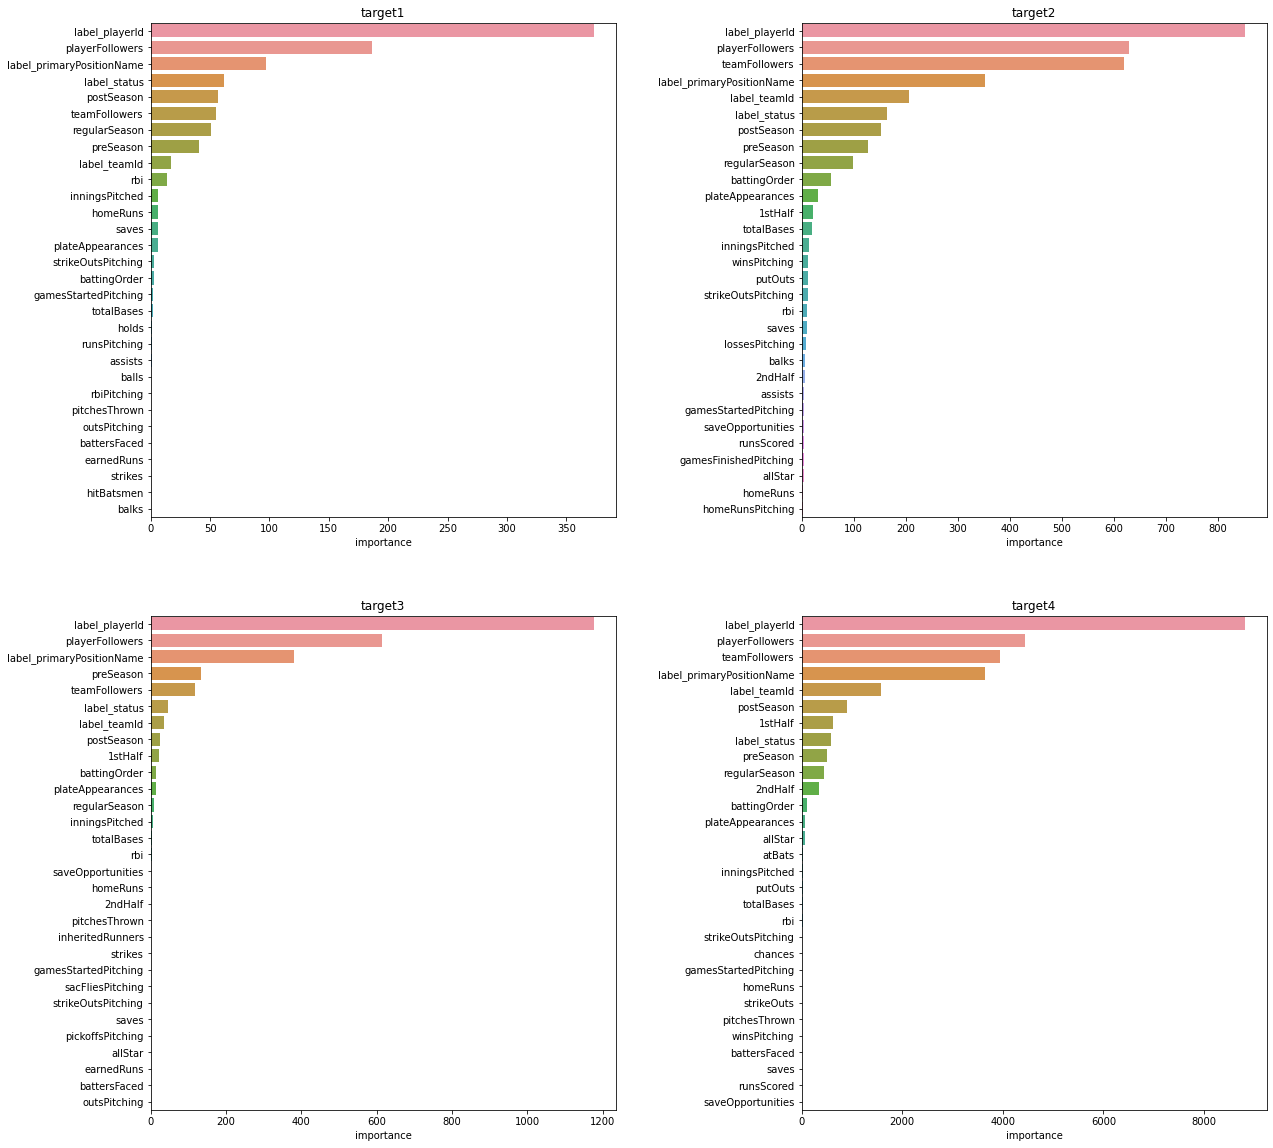

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
models = [model1, model2, model3, model4]

fig, axes = plt.subplots(2, 2, figsize=(20,20))
plt.subplots_adjust(wspace=0.4)
for i, model in enumerate(models):
    
    data = pd.DataFrame({'importance': model.feature_importances_, 'feature': feature_cols}).sort_values('importance', ascending = False)[0:30]

    ax = axes[ i // 2, i % 2]
    ax.yaxis.label.set_visible(False)
    ax.set_title('target' + str(i+1))
    
    sns.barplot(x='importance', y='feature', data=data, ax=ax)

plt.savefig(OUTPUT_DIR / 'feature_importance.png')


# save mlflow

In [18]:
if 'google.colab' in sys.modules:
    import os

    try:
        from google.colab import auth
        auth.authenticate_user()
    except ImportError:
        pass

    REPOSITORY_NAME = 'kaggleops-tutorial'
    PROJECT_ID = 'mlb-project-317407'
    BUCKET_NAME = 'mlb-bucket'

    os.environ["GCLOUD_PROJECT"] = PROJECT_ID

    from google.cloud import storage
    storage_client = storage.Client(project=PROJECT_ID)
    !rm -rf {REPOSITORY_NAME}
    !git clone https://github.com/yuooka/{REPOSITORY_NAME}.git
    !pip install -qr ./{REPOSITORY_NAME}/requirements.txt
    # cd ./{REPOSITORY_NAME}/src
    !gcloud config set project {PROJECT_ID}
    # !gsutil -mq cp -rn gs://{BUCKET_NAME}/mlruns /content/{BUCKET_NAME}/src

    blobs = storage_client.list_blobs(BUCKET_NAME)
    for blob in blobs:
        filepath = blob.name
        if filepath[:7]=="mlruns/" and len(filepath)!=7:
            os.makedirs("/".join(filepath.split("/")[:-1]), exist_ok=True)
            blob.download_to_filename(filepath)

Cloning into 'kaggleops-tutorial'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 69 (delta 22), reused 59 (delta 12), pack-reused 0
Unpacking objects: 100% (69/69), done.
Updated property [core/project].


In [19]:
import mlflow
mlflow.start_run()
mlflow.log_param("feature_cols", feature_cols)
mlflow.log_param("params", params)
mlflow.log_metric('score1', score1)
mlflow.log_metric('score2', score2)
mlflow.log_metric('score3', score3)
mlflow.log_metric('score4', score4)
for i, model in enumerate(models):
    mlflow.log_param('feature_importance_' + str(i+1), model.feature_importances_)
mlflow.log_artifact(OUTPUT_DIR / 'feature_importance.png')
mlflow.end_run()

/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):


In [20]:
if 'google.colab' in sys.modules:
    !python ./{REPOSITORY_NAME}/src/mlproject.py
    # !gsutil -mq cp -rn /content/{REPOSITORY_NAME}/src/mlruns gs://{BUCKET_NAME}

    import glob

    files = [f for f in glob.glob("mlruns/**", recursive=True) if f[:7]=="mlruns/" and len(f)!=7]
    files_in_bucket = [f.name for f in storage_client.list_blobs(BUCKET_NAME)]
    bucket = storage_client.get_bucket(BUCKET_NAME)

    for f in files:
        try:
            if f not in files_in_bucket:
                blob = bucket.blob(f)
                blob.upload_from_filename(f)
        except:
            pass

/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):
Traceback (most recent call last):
  File "./kaggleops-tutorial/src/mlproject.py", line 17, in <module>
    exp_id = client.create_experiment(config['experiment_name'], artifact_location=f"gs://{config['bucket_name']}/artifacts")
  File "/usr/local/lib/python3.7/dist-packages/mlflow/tracking/client.py", line 161, in create_experiment
    return self._tracking_client.create_experiment(name, artifact_location)
  File "/usr/local/lib/python3.7/dist-packages/mlflow/tracking/_tracking_service/client.py", line 128, in create_experiment
    artifact_location=artifact_location,
  File "/usr/local/lib/python3.7/dist-packages/mlflow/store/tracking/file_store.py", line 239, in create_experiment
    self._validate_experiment_n